# Advanced

In [1]:
import pandas as pd
import numpy as np

import ml_project_functions as functions

from matplotlib import pyplot as plt
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

# Data acquisition

In [2]:
# data acquisition from fs

dir_path = ".\\Datasets"

training_advanced = pd.read_json(dir_path + "\\training_advanced_players.json")
test_advanced = pd.read_json(dir_path + "\\test_advanced_players.json")  # test set: False    81, True     19

print("# righe all_advanced : ", training_advanced.shape[0])  # 3367 rows
print(training_advanced['Hof'].value_counts())  # False #   3295, True       72

print("# righe hoa_players: ", test_advanced.shape[0])  # 100 rows
print(test_advanced['Hof'].value_counts())

# righe all_advanced :  3367
Hof
False    3295
True       72
Name: count, dtype: int64
# righe hoa_players:  100
Hof
False    81
True     19
Name: count, dtype: int64


# Plotting

In [ ]:
def dataset_preparation(n_df):
    n_df = n_df[(n_df['G'] >= 100)]  # n_df = n_df[(n_df['To'] - n_df['From'] >= 3)]
    n_df.set_index(pd.Index([i for i in range(n_df.shape[0])]))
    n_df['Hof'] = n_df['Hof'].astype(int)  # n_df.loc[:, 'Hof'] = n_df['Hof'].astype(int)

    if 'PER' in list(n_df.columns):
        # n_df['VORP/48'] = (n_df['VORP'] / n_df['MP']).fillna(0)
        # n_df['DWS/48'] = (n_df['DWS'] * 48 / n_df['MP']).fillna(0)
        # n_df['OWS/48'] = (n_df['OWS'] * 48 / n_df['MP']).fillna(0)
        n_df = n_df.drop(columns=['Unnamed: 14', 'Unnamed: 16', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 21',
                                  'Unnamed: 23', 'Unnamed: 24'])
    else:
        n_df = n_df.drop(columns=['Unnamed: 22', 'Unnamed: 23', 'Unnamed: 29'])

    return n_df.fillna(0).sample(frac=1, random_state=23)

In [3]:
# general data preparation (per plottare)

train_ad_prepared = dataset_preparation(training_advanced.copy())
print(train_ad_prepared.shape[0])
# train_ad_prepared = train_ad_prepared[(train_ad_prepared['G'] >= 100)]
train_ad_prepared['VORP/48'] = (train_ad_prepared['VORP'] / train_ad_prepared['MP']).fillna(0)
train_ad_prepared['DWS/48'] = (train_ad_prepared['DWS'] * 48 / train_ad_prepared['MP']).fillna(0)
train_ad_prepared['OWS/48'] = (train_ad_prepared['OWS'] * 48 / train_ad_prepared['MP']).fillna(0)

1563


In [4]:
# Scaled feature plotting (charts basically will be the same)

train_ad_prepared_scaled_features = train_ad_prepared.copy()
cols48 = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
          'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
          'VORP', 'OWS/48', 'DWS/48', 'VORP/48', 'WS']
scaler = RobustScaler()

train_ad_prepared_scaled_features[cols48] = scaler.fit_transform(train_ad_prepared_scaled_features[cols48])
print(type(train_ad_prepared_scaled_features))

<class 'pandas.core.frame.DataFrame'>


In [8]:
# All or hof
def plotting_dataset(df, columns_map):
    n_df = df.copy()
    size = len(columns_map)

    fig, ax = plt.subplots(size, 1, figsize=(7, 3 * size), constrained_layout=True)
    # width_ratios=[3 for _ in range(size)], height_ratios=[5 for _ in range(size)]

    for i, x_y_list in columns_map.items():
        sub_p = ax if size == 1 else ax[i]
        x_col = x_y_list[0]
        y_col = x_y_list[1]

        sub_p.set_title(f"{x_col} X {y_col}")
        sub_p.set_xlabel(x_col)
        sub_p.set_ylabel(y_col)

        dict = {
            'Not hof': [n_df[x_col][n_df['Hof'] == 0], n_df[y_col][n_df['Hof'] == 0], 'yellow'],
            'Hof': [n_df[x_col][n_df['Hof'] == 1], n_df[y_col][n_df['Hof'] == 1], 'blue'],
            'Mean': [sum(n_df[x_col]) / n_df.shape[0], sum(n_df[y_col]) / n_df.shape[0], 'red']
        }
        for label, list_value in dict.items():
            x_vals = list_value[0]
            y_vals = list_value[1]
            color = list_value[2]
            sub_p.scatter(x_vals, y_vals, color=color, label=label)

        sub_p.legend()

    return fig, ax

(<Figure size 700x1800 with 6 Axes>,
 array([<Axes: title={'center': 'Id X OWS'}, xlabel='Id', ylabel='OWS'>,
        <Axes: title={'center': 'Id X OWS/48'}, xlabel='Id', ylabel='OWS/48'>,
        <Axes: title={'center': 'Id X DWS'}, xlabel='Id', ylabel='DWS'>,
        <Axes: title={'center': 'Id X DWS/48'}, xlabel='Id', ylabel='DWS/48'>,
        <Axes: title={'center': 'OWS X OWS/48'}, xlabel='OWS', ylabel='OWS/48'>,
        <Axes: title={'center': 'DWS X DWS/48'}, xlabel='DWS', ylabel='DWS/48'>],
       dtype=object))

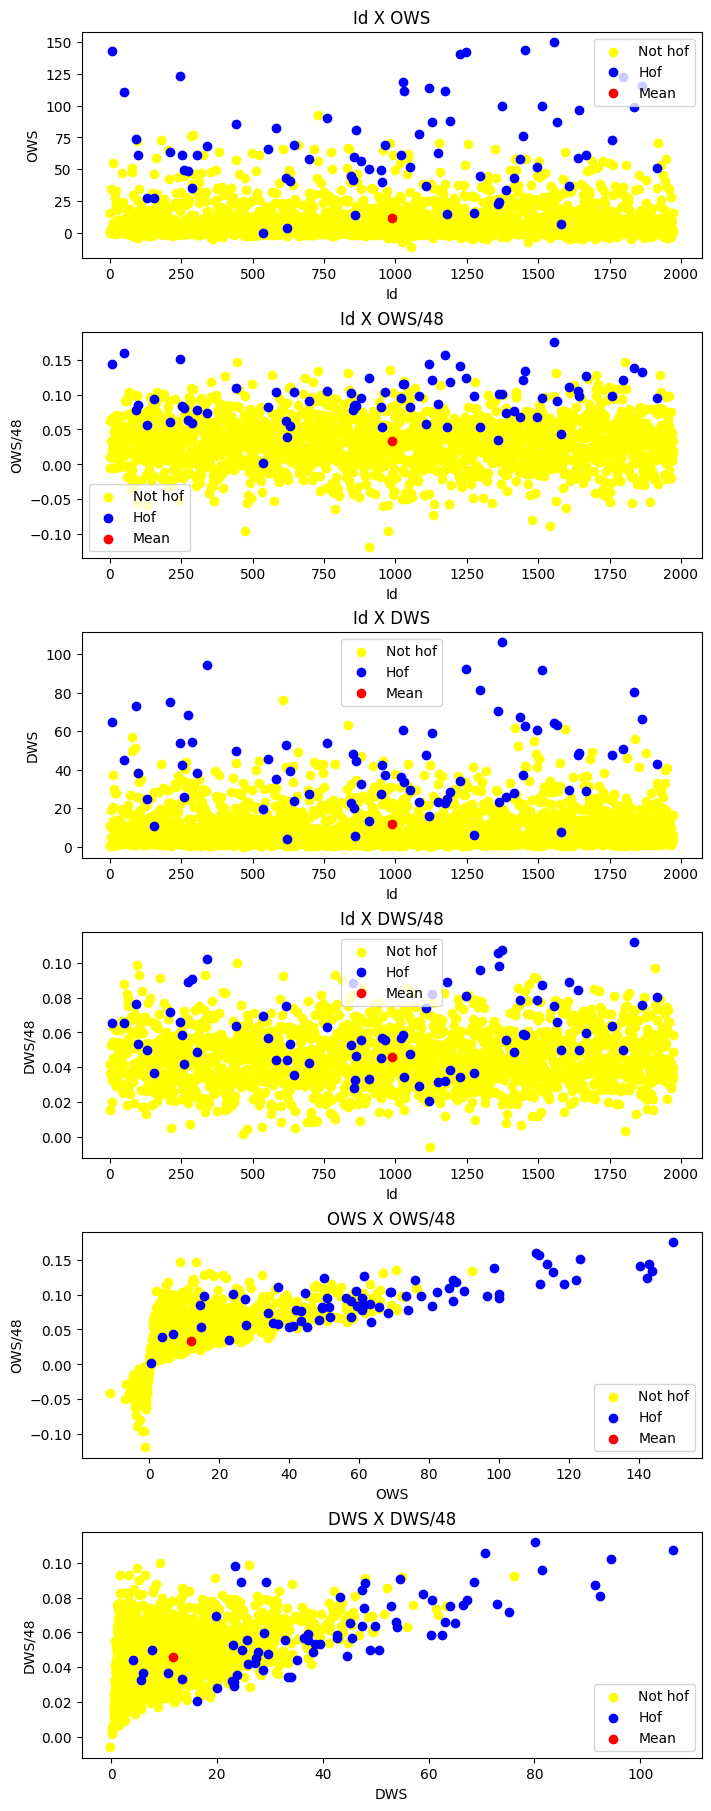

In [9]:
train_ad = train_ad_prepared.copy()
train_ad['Id'] = [i for i in range(train_ad.shape[0])]

dict =  {0 : ['Id', 'OWS'],
         1 : ['Id', 'OWS/48'],
         2 : ['Id', 'DWS'],
         3 : ['Id', 'DWS/48'],
         4 : ['OWS', 'OWS/48'],
         5 : ['DWS', 'DWS/48']}

plotting_dataset(train_ad, dict)

(<Figure size 700x1200 with 4 Axes>,
 array([<Axes: title={'center': 'Id X OWS'}, xlabel='Id', ylabel='OWS'>,
        <Axes: title={'center': 'Id X OWS/48'}, xlabel='Id', ylabel='OWS/48'>,
        <Axes: title={'center': 'Id X DWS'}, xlabel='Id', ylabel='DWS'>,
        <Axes: title={'center': 'Id X DWS/48'}, xlabel='Id', ylabel='DWS/48'>],
       dtype=object))

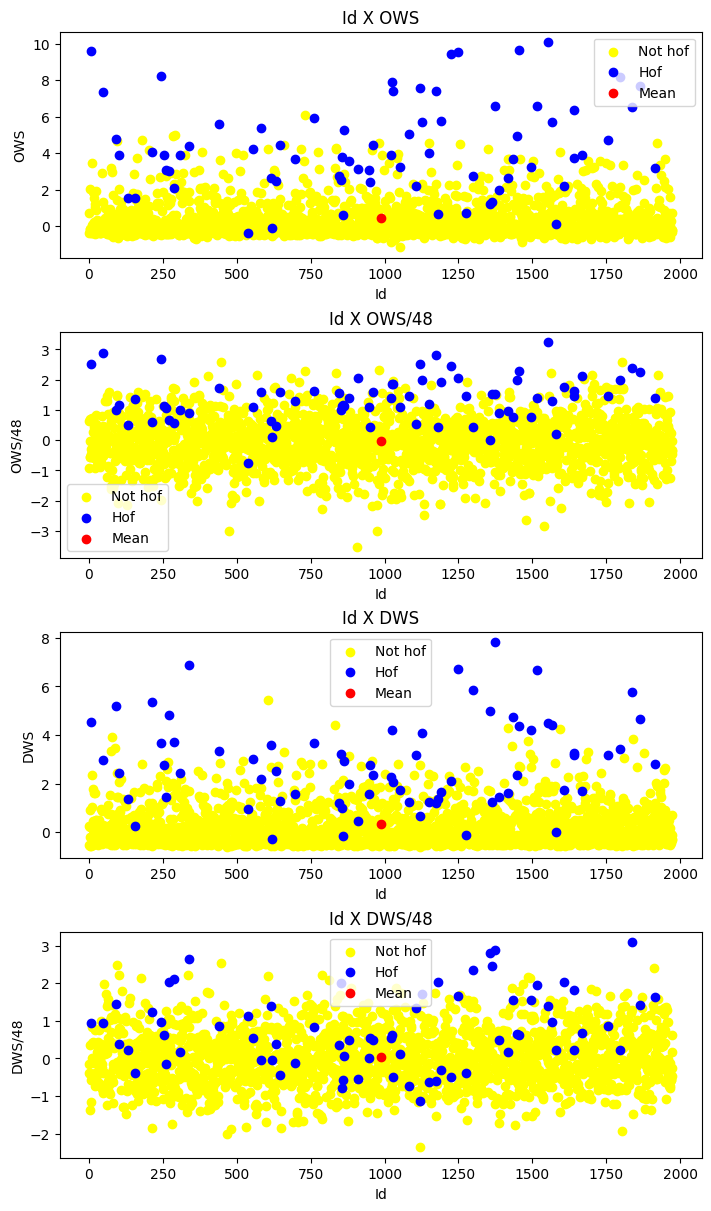

In [12]:
# Feature scaled
train_ad = train_ad_prepared_scaled_features.copy()
train_ad['Id'] = [i for i in range(train_ad.shape[0])]

dict =  {0 : ['Id', 'OWS'],
         1 : ['Id', 'OWS/48'],
         2 : ['Id', 'DWS'],
         3 : ['Id', 'DWS/48']}

plotting_dataset(train_ad, dict)

(<Figure size 700x1200 with 4 Axes>,
 array([<Axes: title={'center': 'OWS X OWS/48'}, xlabel='OWS', ylabel='OWS/48'>,
        <Axes: title={'center': 'DWS X DWS/48'}, xlabel='DWS', ylabel='DWS/48'>,
        <Axes: title={'center': 'WS X WS/48'}, xlabel='WS', ylabel='WS/48'>,
        <Axes: title={'center': 'VORP X VORP/48'}, xlabel='VORP', ylabel='VORP/48'>],
       dtype=object))

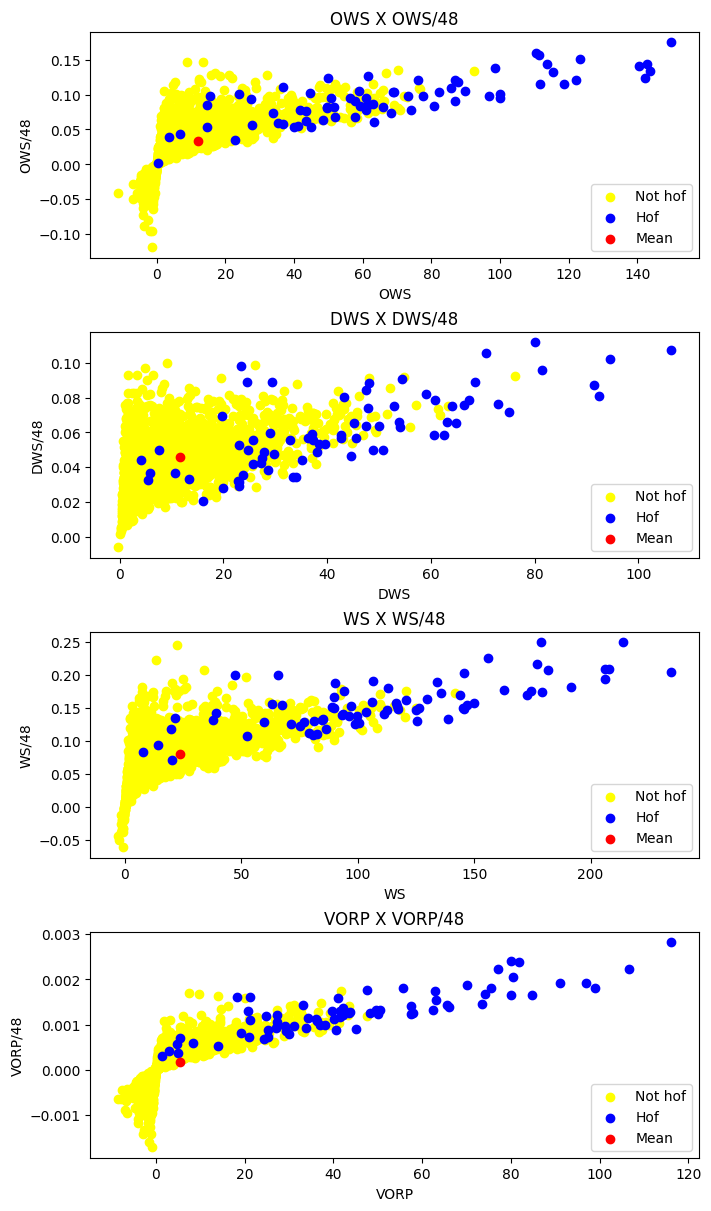

In [11]:
train_ad = train_ad_prepared.copy()

dict =  {0 : ['OWS', 'OWS/48'],
         1 : ['DWS', 'DWS/48'],
         2 : ['WS', 'WS/48'],
         3 : ['VORP', 'VORP/48']}

plotting_dataset(train_ad, dict)

# General data preparation

In [3]:
def dataset_preparation(n_df):
    n_df = n_df[(n_df['G'] >= 100)]  # n_df = n_df[(n_df['To'] - n_df['From'] >= 3)]
    n_df.set_index(pd.Index([i for i in range(n_df.shape[0])]))
    n_df['Hof'] = n_df['Hof'].astype(int)  # n_df.loc[:, 'Hof'] = n_df['Hof'].astype(int)

    if 'PER' in list(n_df.columns):
        n_df = n_df.drop(columns=['Unnamed: 14', 'Unnamed: 16', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 21',
                                  'Unnamed: 23', 'Unnamed: 24'])
    else:
        n_df = n_df.drop(columns=['Unnamed: 22', 'Unnamed: 23', 'Unnamed: 29'])

    return n_df.fillna(0).sample(frac=1, random_state=23)

In [4]:
# general data preparation 

training_advanced_prepared = dataset_preparation(training_advanced.copy())
print("Training dataset size after preparation: ", training_advanced_prepared.shape[0])
training_advanced_prepared['VORP'] = (training_advanced_prepared['VORP'] / training_advanced_prepared['MP']).fillna(0)
training_advanced_prepared['DWS'] = (training_advanced_prepared['DWS'] * 48 / training_advanced_prepared['MP']).fillna(0)
training_advanced_prepared['OWS'] = (training_advanced_prepared['OWS'] * 48 / training_advanced_prepared['MP']).fillna(0)
training_advanced_prepared.drop('WS', axis=1, inplace=True)

test_advanced_prepared = dataset_preparation(test_advanced.copy())
print("Test dataset size after preparation: ", test_advanced_prepared.shape[0])
test_advanced_prepared['VORP'] = (test_advanced_prepared['VORP'] / test_advanced_prepared['MP']).fillna(0)
test_advanced_prepared['DWS'] = (test_advanced_prepared['DWS'] * 48 / test_advanced_prepared['MP']).fillna(0)
test_advanced_prepared['OWS'] = (test_advanced_prepared['OWS'] * 48 / test_advanced_prepared['MP']).fillna(0)
test_advanced_prepared.drop('WS', axis=1, inplace=True)


Training dataset size after preparation:  1975
Test dataset size after preparation:  100


In [5]:
print(training_advanced_prepared['Player'][training_advanced_prepared['Hof'] == 1].shape[0])
print(training_advanced_prepared['Player'][training_advanced_prepared['Hof'] == 0].shape[0])
print(test_advanced_prepared['Player'][test_advanced_prepared['Hof'] == 1].shape[0])
print(test_advanced_prepared['Player'][test_advanced_prepared['Hof'] == 0].shape[0])

72
1903
19
81


In [6]:
# Valid features

advanced_columns = list(training_advanced_prepared.columns)
columns_to_remove = ['Age', 'Pos', 'G', 'MP', 'From', 'To', 'Player', 'Hof']
valid_advanced_columns = list(filter(lambda column: column not in columns_to_remove, advanced_columns))

# Scaling features

## Robust scaling features

In [7]:
# Scaling features(Robust scaler, numpy) 

training_ad = training_advanced_prepared.copy()
test_ad = test_advanced_prepared.copy()
valid_ad_cols = valid_advanced_columns[:]

r_scaler = RobustScaler()

training_advanced_scaled = pd.DataFrame(r_scaler.fit_transform(training_ad[valid_ad_cols]), columns=valid_ad_cols, index=training_ad.index)
training_advanced_scaled[['MP', 'Player', 'Hof']] = training_ad[['MP', 'Player', 'Hof']]

test_advanced_scaled = pd.DataFrame(r_scaler.fit_transform(test_ad[valid_ad_cols]), columns=valid_ad_cols, index=test_ad.index)
test_advanced_scaled[['MP', 'Player', 'Hof', 'HoF Prob']] = test_ad[['MP', 'Player', 'Hof', 'HoF Prob']]

# Feature selection methods 

## RFECV

In [8]:
# Feature selection: RFECV

def select_features_rfecv(model, n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']

    # rfe = RFE(estimator=model, n_features_to_select=int(len(n_columns)/2)).fit(X, y)
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits=7), scoring="f1_weighted", min_features_to_select=4, n_jobs=-1)
    
    rfecv.fit(X, y)

    print(f"# features selected: {rfecv.n_features_}")
    selected_features = list(X.columns[rfecv.support_])
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

## Select k-best

In [9]:
# Feature selection: select k-best

def select_features_skb(n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']

    selector = SelectKBest(score_func=f_classif).fit(X, y)

    indices = selector.get_support(indices=True)
    selected_features = [n_columns[index] for index in indices]

    print(f"Optimal number of features: {len(selected_features)}")
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

## Select From Model

In [10]:
# Feature select: Select From Model

def select_features_sfm(model, n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']
    
    selector = SelectFromModel(estimator=model).fit(X, y)

    # mask = selector.get_support() selected_features = list(filter(lambda x: mask[columns.index(x)], columns))
    indices = selector.get_support(indices=True)
    selected_features = [n_columns[index] for index in indices]

    print(f"Optimal number of features: {len(selected_features)}")
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

# Training and test process function

In [11]:
def cross_validating_model(model, X, y):
    cv_results_model = cross_validate(model, X, y, cv=5, scoring=['precision', 'recall'])
    mean_precision_model = np.mean(cv_results_model['test_precision'])
    mean_recall_model = np.mean(cv_results_model['test_recall'])
    print("Cross validation mean precision on training set: ", mean_precision_model)
    print(f"Cross validation mean recall on training set: {mean_recall_model}\n")

In [12]:
def plotting_class_report(class_reports_pl_dict, df_columns, colors, title):
    # class_report_pl_dict = {'TN' : true_negatives_players, 'FN' : false_negatives_players,
    # 'TP', : true_positives_players, 'FP' : false_positives_players}
    # colors = ['yellow', 'pink', 'blue', 'lightcyan']

    fig, ax = plt.subplots(len(df_columns), 1, figsize=(7, 3 * len(df_columns)), constrained_layout=True)

    fig.suptitle(title, fontsize=16)
    print(df_columns)
    for i, column in enumerate(df_columns):  # a plot for each feature (with index on x-coordinate)
        sub_plot = ax[i]
        sub_plot.set_xlabel('Id')
        sub_plot.set_ylabel(column)
        sub_plot.set_title('Id x ' + column)
        for j, (key, value) in enumerate(class_reports_pl_dict.items()):
            sub_plot.scatter(class_reports_pl_dict[key].index, class_reports_pl_dict[key][column], color=colors[j],
                             label=key)

        sub_plot.legend()

    return fig, ax

In [31]:
# Classification statistics and plotting selected features

def evaluating_classification_model(y_p, y_t, df, columns, title, p_show):
    print("Feature Columns (list) used for training and test process: ")
    print(f"{columns}\n")

    actual_negatives = y_t[y_t == 0]
    actual_positives = y_t[y_t == 1]
    predicted_negatives = y_p[y_p == 0]
    predicted_positives = y_p[y_p == 1]
    true_negatives = y_t[(y_p == y_t) & (y_p == 0)]
    false_negatives = y_t[(y_p != y_t) & (y_p == 0)]
    true_positives = y_t[(y_p == y_t) & (y_p == 1)]
    false_positives = y_t[(y_p != y_t) & (y_p == 1)]

    print("Actual negatives: ", actual_negatives.size)
    print("Actual positives: ", actual_positives.size)
    print("Predicted negatives: ", predicted_negatives.size)
    print("Predicted positives: ", predicted_positives.size)
    print("True negatives (how many of the predicts are really negative): ",
          true_negatives.size)
    print("False negatives (predicted negatives that are actual positive): ",
          false_negatives.size)  # FN (predicted negatives that are actual positives)
    print("True positives (how many of the predicts are really positive): ",
          true_positives.size)
    print("False positives (predicted positives that are actual negative): ",
          false_positives.size)  # FP (predicted positives that are actual negatives)

    true_negatives_players = df.loc[true_negatives.index]
    false_negatives_players = df.loc[false_negatives.index]
    true_positives_players = df.loc[true_positives.index]
    false_positives_players = df.loc[false_positives.index]

    print("PLayer not Hof (True Negatives):")
    print(true_negatives_players['Player'])
    print("Players really Hof that predicted not (False Negatives): ")
    print(false_negatives_players['Player'])
    print("Players true hof (True Positives): ")
    print(true_positives_players['Player'])
    print("PLayers not Hof that predicted so (False positives): ")
    print(false_positives_players['Player'])

    class_report = classification_report(y_t, y_p)
    print("Classification Report:")
    print(f"{class_report}\n")

    # labels = ['true negatives', 'false negatives', 'true positives', 'false positives'], df = df[columns]

    class_report_players_dict = {
        'TN': true_negatives_players,
        'FN': false_negatives_players,
        'TP': true_positives_players,
        'FP': false_positives_players
    }

    if p_show:
        print("Ok let's plot it")
        start_plotting_column = 0 - int(len(columns) / 2)  # si possono plottare tutte le feature volendo
        list_plotting_columns = columns[start_plotting_column:] if len(columns) > 10 else columns
        fig, ax = plotting_class_report(class_report_players_dict, list_plotting_columns,
                                        ['yellow', 'pink', 'blue', 'lightcyan'], title)
        return fig, ax, classification_report(y_t, y_p, output_dict=True)

    return None, None, classification_report(y_t, y_p, output_dict=True)

In [14]:
def probability_hof_comparing(model, X_t, n_df):
    y_proba = model.predict_proba(X_t)
    y_proba_df = pd.DataFrame(y_proba[:, 1], index=n_df.index, columns=['model_hof prob'])
    y_proba_df['Player'] = n_df['Player']
    y_proba_df['Hof prob'] = n_df['HoF Prob']
    y_proba_df['diff_prob'] = (y_proba_df['model_hof prob'] - y_proba_df['Hof prob']).abs()
    y_proba_diff_df = y_proba_df.loc[y_proba_df['diff_prob'] > 0.15, ['Player', 'model_hof prob', 'Hof prob']]
    print("# players with >0.15 diff. on hof prob. : ", y_proba_diff_df.shape[0])
    print(f"{y_proba_diff_df}\n")

    return y_proba_df, y_proba_diff_df

In [15]:
def train_test_pipeline(model, train_n_df, test_n_df, sel_features, plotted):
    
    X = train_n_df[sel_features]
    y = train_n_df['Hof']

    cross_validating_model(model, X, y)

    model.fit(X, y)

    X_test = test_n_df[sel_features]
    y_test = test_n_df['Hof']

    y_pred = model.predict(X_test)  # y_pred = pd.Series(y_pred, index=y_test.index)
    fig, ax, class_p = evaluating_classification_model(y_pred, y_test, test_n_df, list(X_test.columns), 'Prediction', plotted)
    y_proba_df, y_proba_diff_df = probability_hof_comparing(model, X_test, test_n_df)
    # # return { 'figure' : fig,
    #          'axes' : ax,
    #          'classes_p' : class_p, 
    #          'y_proba' : y_proba_df, 
    #          'y_proba_diff' : y_proba_diff_df}

# Logistic regression

## Model definition

In [17]:
# Model definition: Logistic Regression

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

## Logistic regression with no feature selection

In [18]:
# Training and test process (Robust scaling) with no feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

print("Training and test process (Robust scaling) with no feature selection")

train_test_pipeline(model_LR, training_advanced_scaled.copy(), test_advanced_scaled.copy(), valid_advanced_columns[:], False)

Training and test process (Robust scaling) with no feature selection
Cross validation mean precision on training set:  0.30544342479125086
Cross validation mean recall on training set:  0.8885714285714286
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 75
Predicted positives: 25
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto 

## Logistic regression with feature selection

### RFECV

Training and test process (Robust scaling) with refcv feature selection
Optimal number of features: 10
Selected features:
['PER', '3PAr', 'ORB%', 'AST%', 'TOV%', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.2973581341874025
Cross validation mean recall on training set:  0.9019047619047619
Feature Columns (list) used for training and test process: 
['PER', '3PAr', 'ORB%', 'AST%', 'TOV%', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 77
Predicted positives: 23
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...      

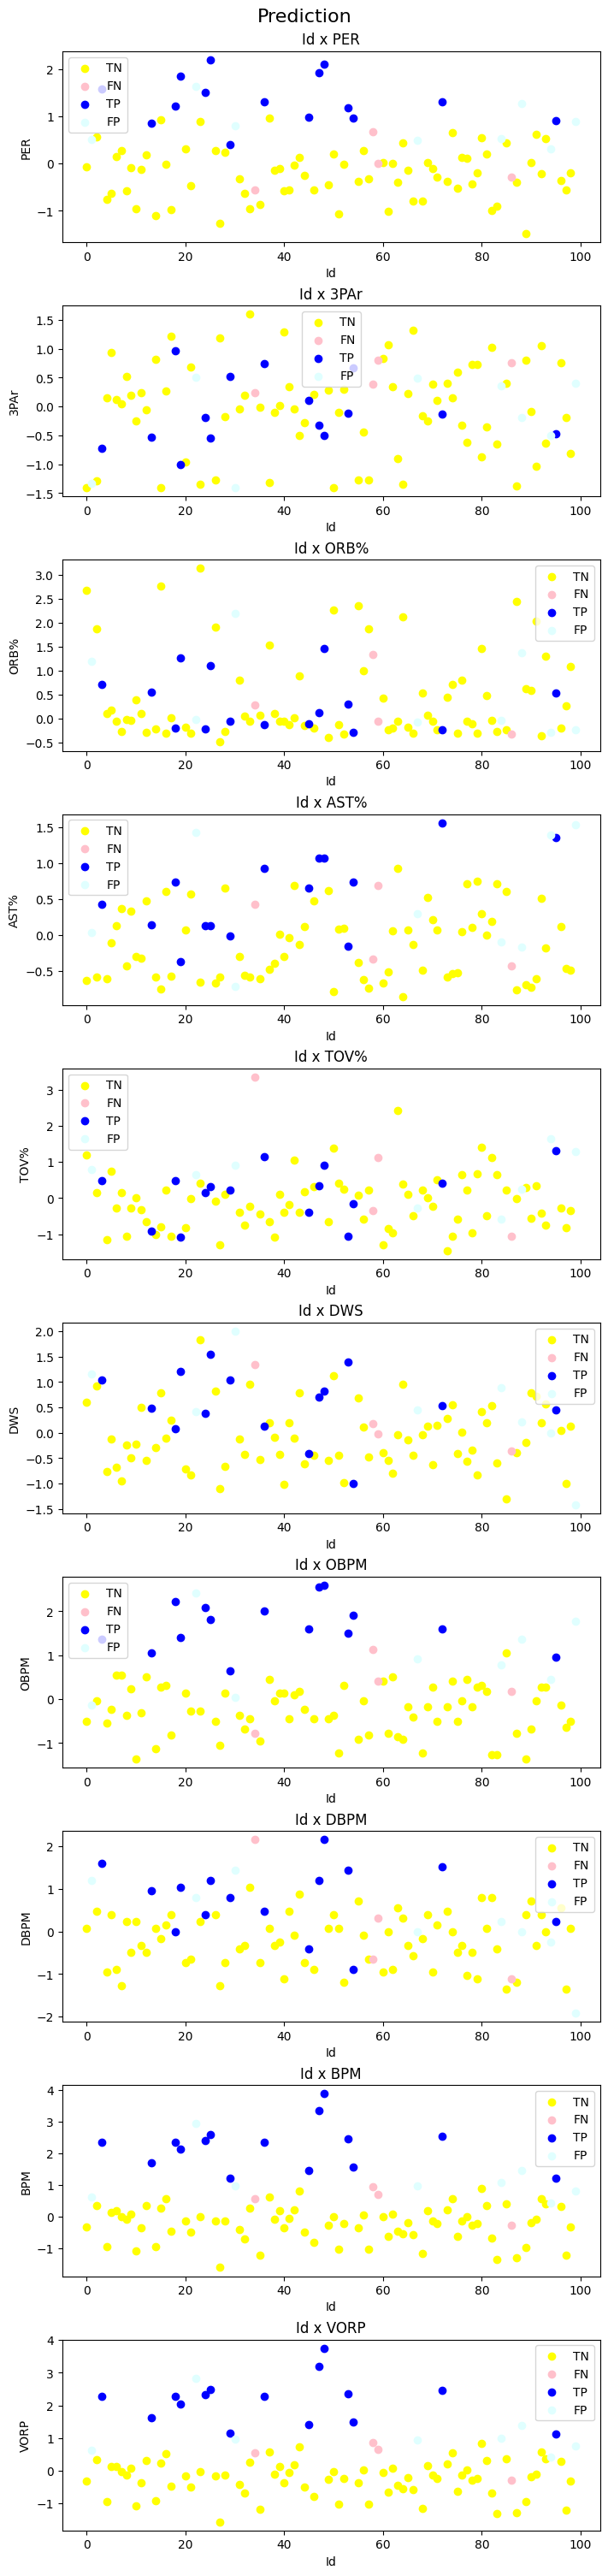

In [19]:
# Training and test process (Robust scaling) with refcv feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

print("Training and test process (Robust scaling) with refcv feature selection")

selected_features_LR_rfecv = select_features_rfecv(model_LR, training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_LR, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_LR_rfecv, True)

### Select k-best

Training and test process (Robust scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.26072466581557674
Cross validation mean recall on training set:  0.8742857142857142
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
7

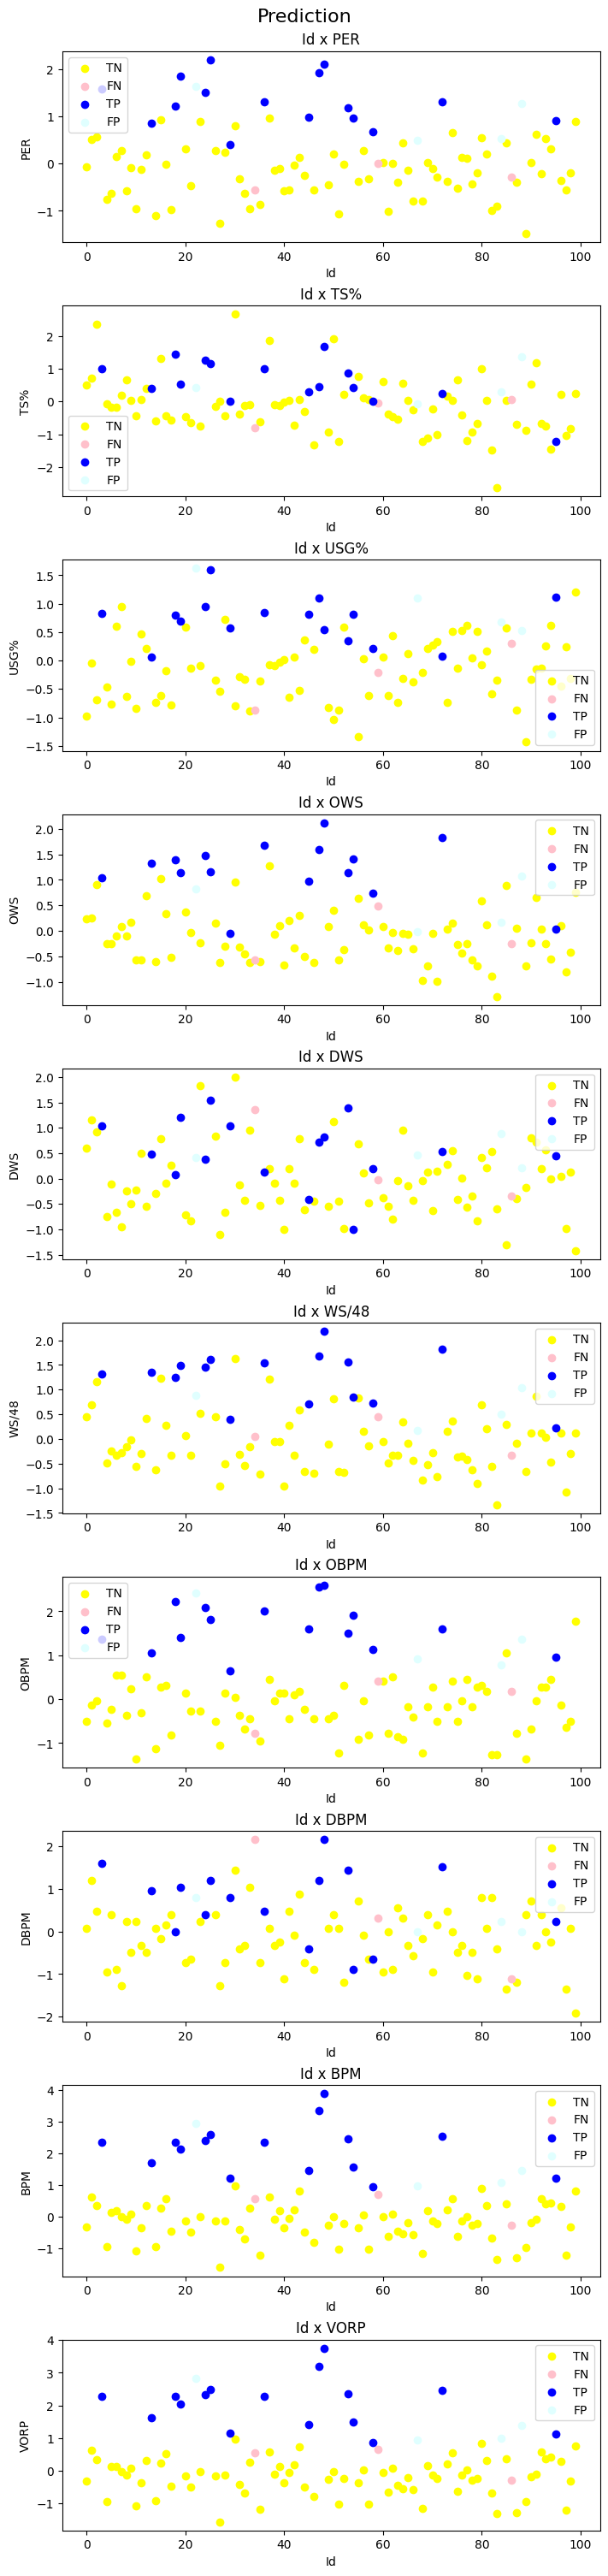

In [20]:
# Training and test process (Robust scaling) with skb feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

print("Training and test process (Robust scaling) with skb feature selection")

selected_features_LR_skb = select_features_skb(training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_LR, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_LR_skb, True)

### Select From Model

In [21]:
# Training and test process (Robust scaling) with sfm feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

print("Training and test process (Robust scaling) with sfm feature selection")

selected_features_LR_sfm = select_features_sfm(model_LR, training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_LR, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_LR_sfm, False)

Training and test process (Robust scaling) with sfm feature selection
Optimal number of features: 8
Selected features:
['3PAr', 'ORB%', 'AST%', 'TOV%', 'DWS', 'OBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.2880810427151891
Cross validation mean recall on training set:  0.9019047619047619
Feature Columns (list) used for training and test process: 
['3PAr', 'ORB%', 'AST%', 'TOV%', 'DWS', 'OBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  75
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  6
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31      

## Logistic Regression with manual feature selection

In [22]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

### Training and test process 

In [23]:
# Training and test process (Robust scaling) with manual feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')

print("Training and test process (Robust scaling) with manual feature selection")

train_test_pipeline(model_LR, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_manual, False)

Training and test process (Robust scaling) with manual feature selection
Cross validation mean precision on training set:  0.24446253345227476
Cross validation mean recall on training set:  0.8466666666666667
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Leng

____________________________________________________________________________________________________________________

# Support Vector Classifier

### Model definition

In [24]:
# Model definition

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

## Support Vector Classifier with no feature selection

In [27]:
# Training and test process (Robust scaling) with no feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

print("Training and test process (Robust scaling) with no feature selection")

train_test_pipeline(model_SVC, training_advanced_scaled.copy(), test_advanced_scaled.copy(), valid_advanced_columns[:], False)

Training and test process (Robust scaling) with no feature selection
Cross validation mean precision on training set:  0.298942036645525
Cross validation mean recall on training set:  0.86
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 75
Predicted positives: 25
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40   

## Support Vector Classifier with feature selection

### RFECV

In [60]:
# Training and test process (Robust scaling) with rfecv feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

print("Training and test process (Robust scaling) with rfecv feature selection")

selected_features_SVC_rfecv = select_features_rfecv(model_SVC, training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_SVC, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_SVC_rfecv, False)

Training and test process (Robust scaling) with rfecv feature selection
Optimal number of features: 14
Selected features:
['PER', 'TS%', '3PAr', 'ORB%', 'TRB%', 'AST%', 'TOV%', 'USG%', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.30224870657797487
Cross validation mean recall on training set:  0.8742857142857142
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'ORB%', 'TRB%', 'AST%', 'TOV%', 'USG%', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 75
Predicted positives: 25
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77

### Select k-best

Training and test process (Robust scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.2660670553236318
Cross validation mean recall on training set:  0.8742857142857142
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76

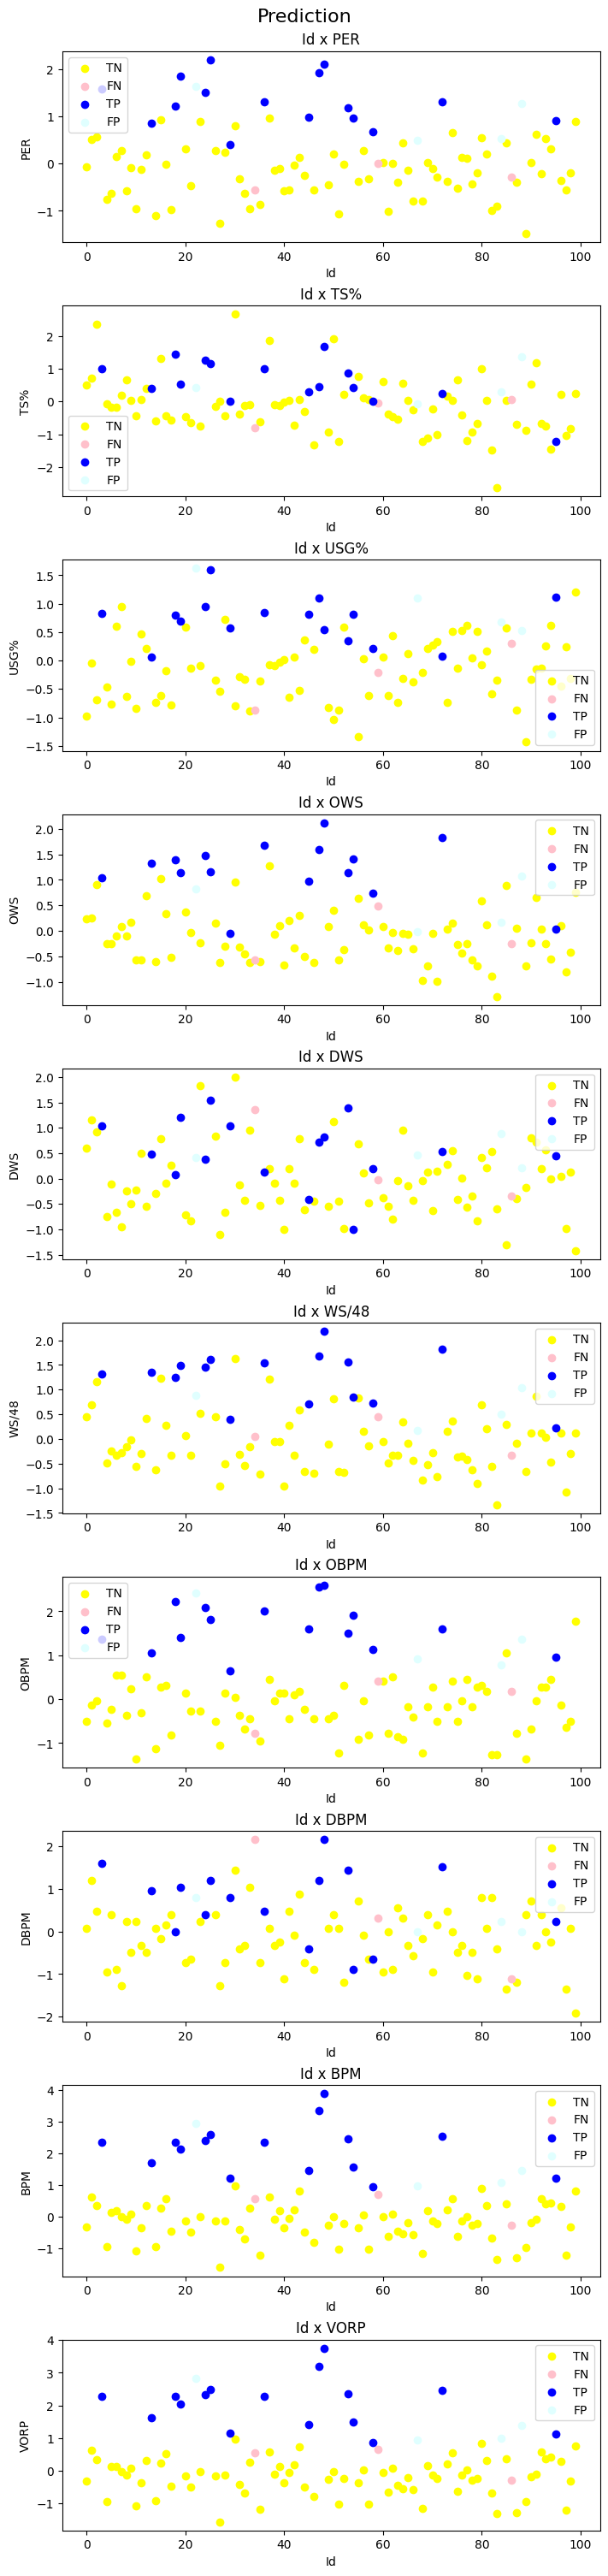

In [28]:
# Training and test process (Robust scaling) with skb feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

print("Training and test process (Robust scaling) with skb feature selection")

selected_features_SVC_skb = select_features_skb(training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_SVC, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_SVC_skb, True)

### Selected From Model

Training and test process (Robust scaling) with sfm feature selection
Optimal number of features: 11
Selected features:
['PER', '3PAr', 'ORB%', 'AST%', 'TOV%', 'USG%', 'DWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.29557173452522295
Cross validation mean recall on training set:  0.8885714285714286
Feature Columns (list) used for training and test process: 
['PER', '3PAr', 'ORB%', 'AST%', 'TOV%', 'USG%', 'DWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 75
Predicted positives: 25
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
    

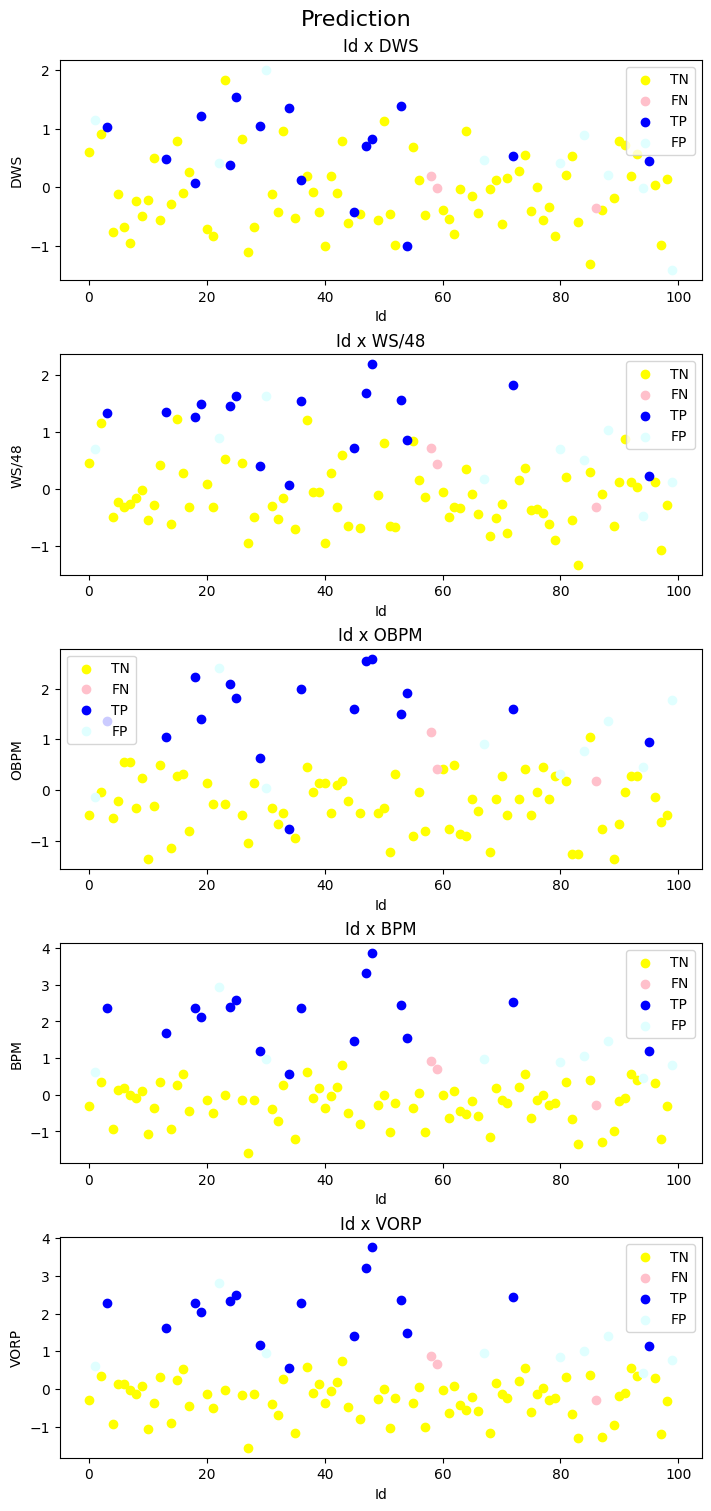

In [32]:
# Training and test process (Robust scaling) with sfm feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

print("Training and test process (Robust scaling) with sfm feature selection")

selected_features_SVC_sfm = select_features_sfm(model_SVC, training_advanced_scaled.copy(), valid_advanced_columns[:])

train_test_pipeline(model_SVC, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_SVC_sfm, True)

## Support Vector Classifier with manual feature selection

In [64]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

### Training and test process

Training and test process (Robust scaling) with manual feature selection
Cross validation mean precision on training set:  0.2605368831263811
Cross validation mean recall on training set:  0.8609523809523809
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Lengt

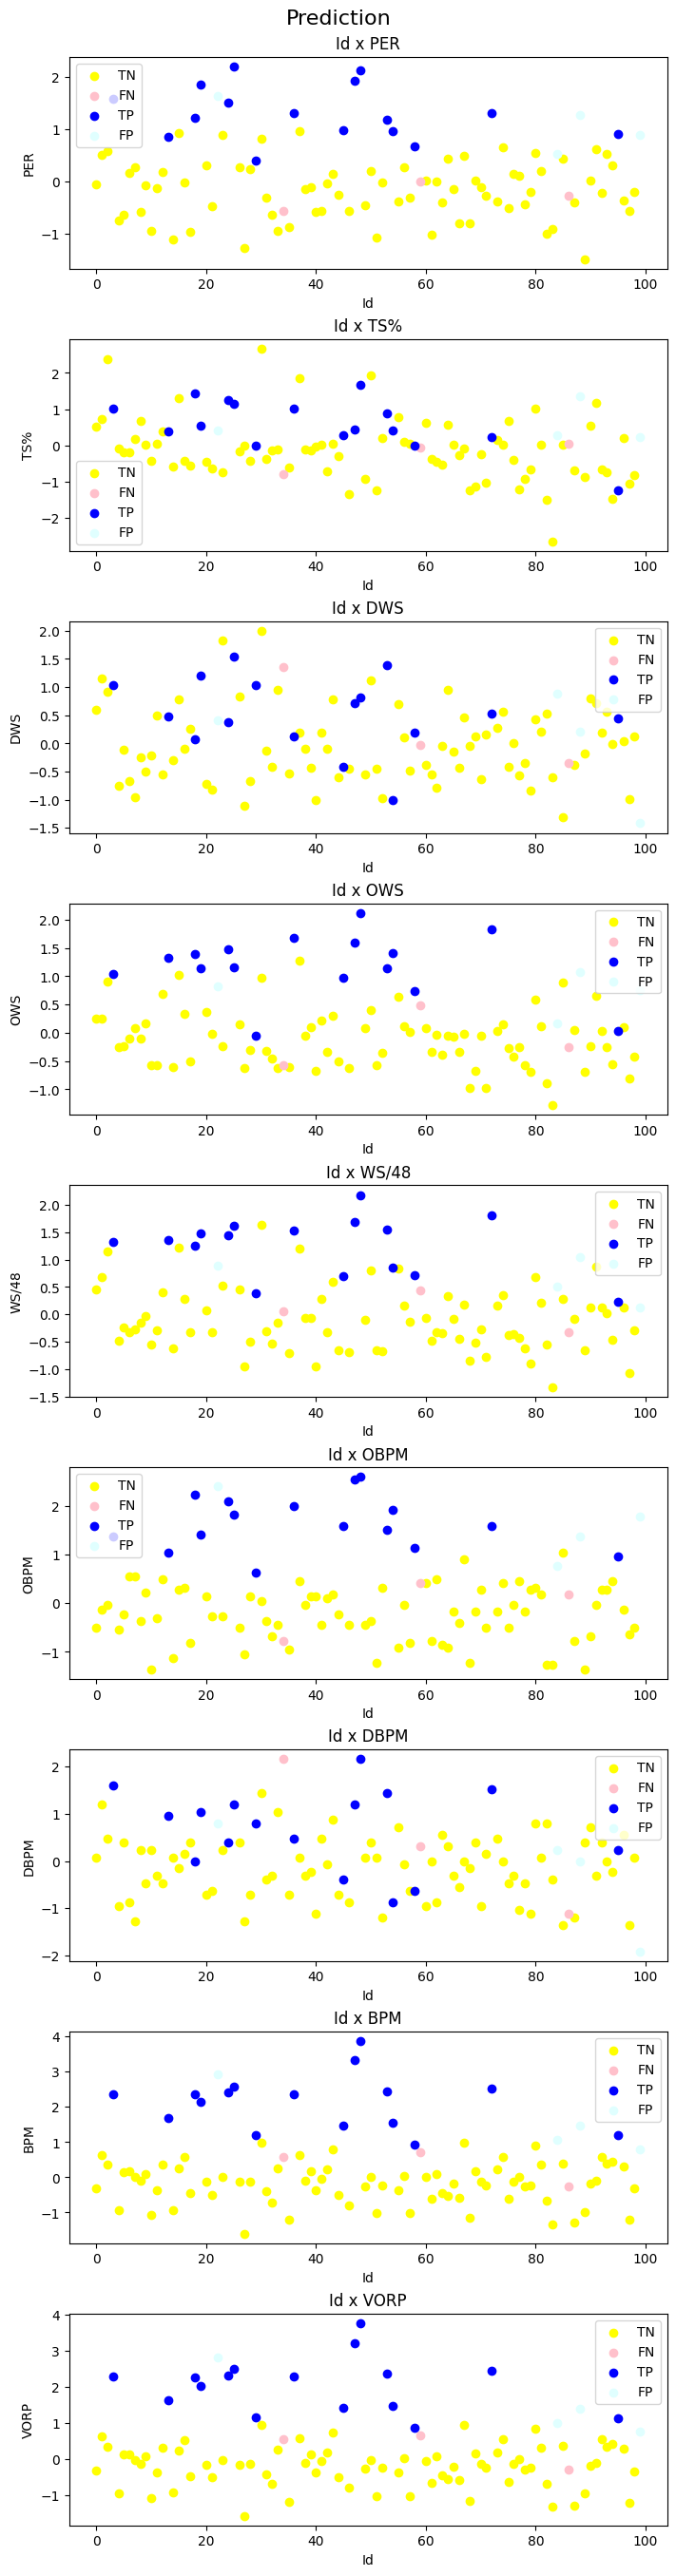

In [33]:
# Training and test process (Robust scaling) with manual feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear')

print("Training and test process (Robust scaling) with manual feature selection")

train_test_pipeline(model_SVC, training_advanced_scaled.copy(), test_advanced_scaled.copy(), selected_features_manual, True)

_______________________________________________________________________________________________________________________

# Decision tree

### Model definition

In [66]:
# Model definition

model_DTC = tree.DecisionTreeClassifier(random_state=23)
model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

## Decision tree with no feature selection

In [73]:
# Training and test process (no scaling and no weighted classes) with no feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns[:], False)

Training and test process (no scaling and no weighted classes) with no feature selection
Cross validation mean precision on training set:  0.3968831168831169
Cross validation mean recall on training set:  0.439047619047619
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 82
Predicted positives: 18
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron G

In [74]:
# Training and test process (no scaling) with no feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns[:], False)

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.42597402597402595
Cross validation mean recall on training set:  0.3466666666666667
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 84
Predicted positives: 16
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  11
True positives (how many of the predicts are really positive):  8
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Port

## Decision tree feature selection

### RFECV

Training and test process (no scaling and no weighted classes) with rfecv feature selection
Optimal number of features: 16
Selected features:
['PER', 'TS%', '3PAr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.3888888888888889
Cross validation mean recall on training set:  0.41142857142857137
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 83
Predicted positives: 17
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors


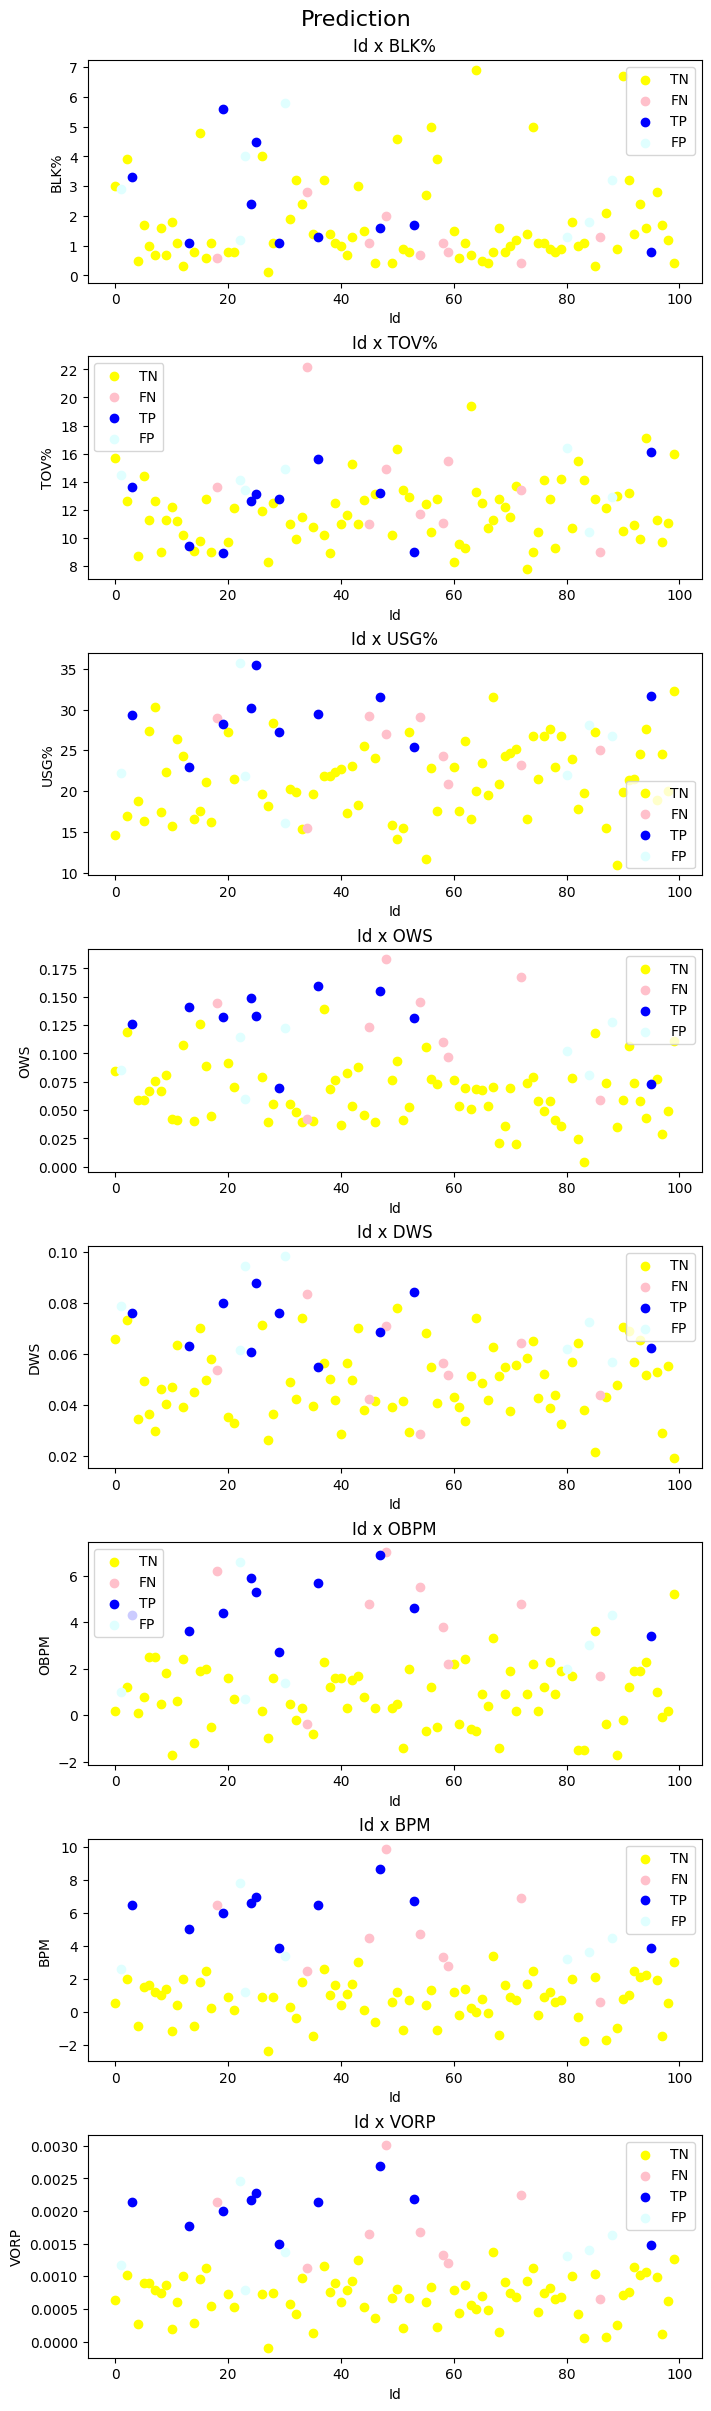

In [34]:
# Training and test process (no scaling and no weighted classes) with rfecv feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with rfecv feature selection")

selected_features_DTC_rfecv = select_features_rfecv(model_DTC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_rfecv, True)

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 5
Selected features:
['PER', '3PAr', 'STL%', 'USG%', 'VORP']
Cross validation mean precision on training set:  0.41861471861471866
Cross validation mean recall on training set:  0.46761904761904766
Feature Columns (list) used for training and test process: 
['PER', '3PAr', 'STL%', 'USG%', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26       Derrick Favors
82         Marcus Smart
68      Markieff Morris
37     Montrezl Harrell
55         Kevon Looney
            ...        
91    Jonas Valančiūnas
31         Aaron Gordon
73      Otto Porter Jr.

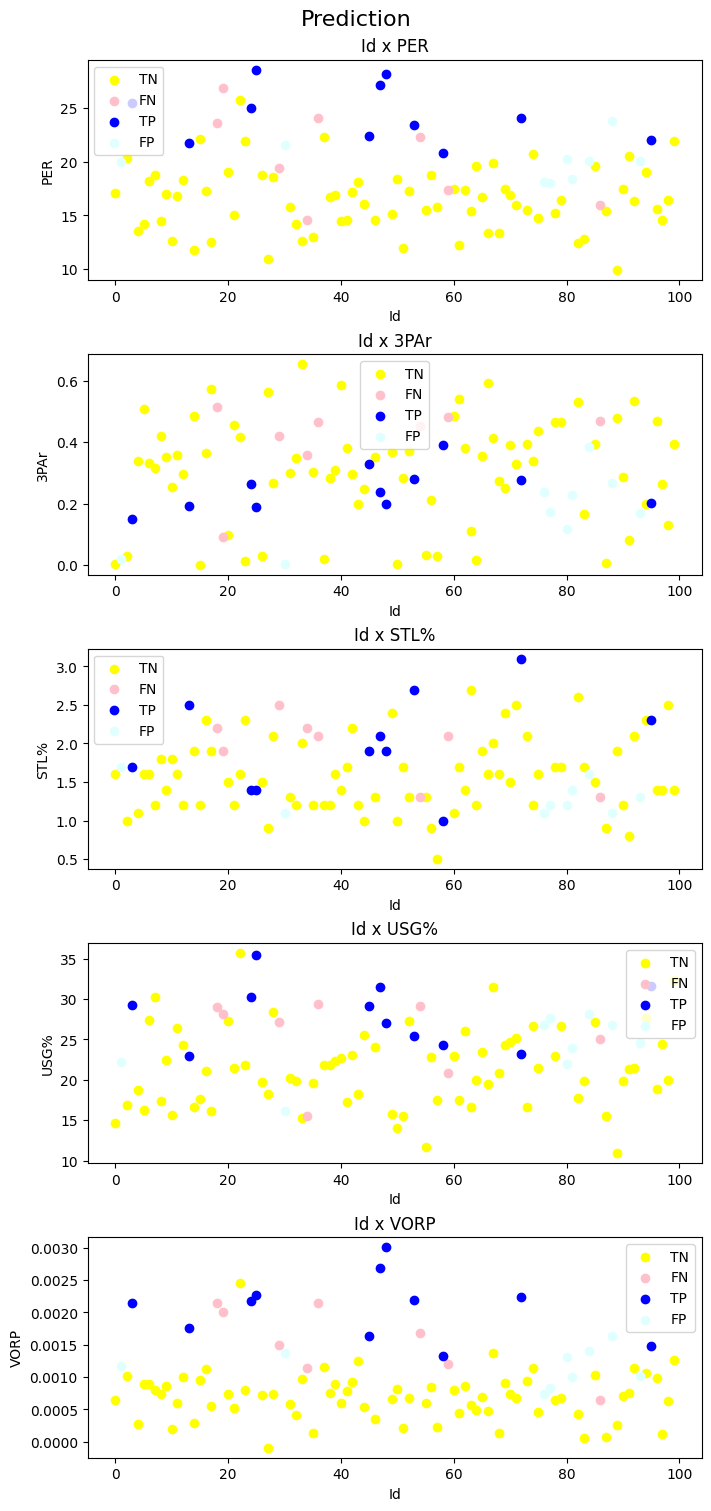

In [35]:
# Training and test process (no scaling) with rfecv feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_DTC_rfecv = select_features_rfecv(model_DTC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_rfecv, True)

### Select k-best 

In [87]:
# Training and test process (no scaling and no weighted classes) with skb feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_DTC_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_skb, False)

Training and test process (no scaling and no weighted classes) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.4628205128205128
Cross validation mean recall on training set:  0.3980952380952381
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 76
Predicted positives: 24
True negatives (how many of the predicts are really negative):  70
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  11
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
    

In [36]:
# Training and test process (no scaling) with skb feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_DTC_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.47827219564061674
Cross validation mean recall on training set:  0.4
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 77
Predicted positives: 23
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26       Derrick Favors
80     Domantas Sabonis
82         Marcus Smart
68      Markieff Morris
37     Montrezl Harrell
            ...        
91    Jonas Va

### Select From Model

In [37]:
# Training and test process (no feature selection) with sfm feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no feature selection) with sfm feature selection")

selected_features_DTC_sfm = select_features_sfm(model_DTC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_sfm, False)

Training and test process (no feature selection) with sfm feature selection
Optimal number of features: 6
Selected features:
['PER', '3PAr', 'DRB%', 'TRB%', 'OBPM', 'VORP']
Cross validation mean precision on training set:  0.4640184453227931
Cross validation mean recall on training set:  0.5
Feature Columns (list) used for training and test process: 
['PER', '3PAr', 'DRB%', 'TRB%', 'OBPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26       Derrick Favors
82         Marcus Smart
68      Markieff Morris
77         Derrick Rose
55         Kevon Looney
            ...        
91    Jonas Valančiūnas
76        Julius Randle
31         Aaron

Training and test process (no feature selection and weighted classes) with sfm feature selection
Optimal number of features: 2
Selected features:
['PER', 'VORP']
Cross validation mean precision on training set:  0.4818315018315018
Cross validation mean recall on training set:  0.3885714285714285
Feature Columns (list) used for training and test process: 
['PER', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 74
Predicted positives: 26
True negatives (how many of the predicts are really negative):  69
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  12
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83   

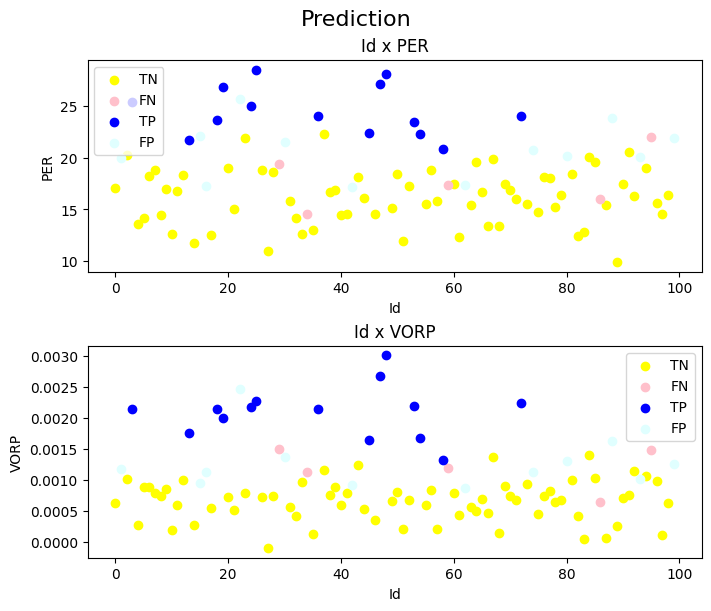

In [42]:
# Training and test process (no feature selection and weighted classes) with sfm feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no feature selection and weighted classes) with sfm feature selection")

selected_features_DTC_sfm = select_features_sfm(model_DTC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_DTC_sfm, True)

## Decision tree with manual feature selection

In [83]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

In [85]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with manual feature selection")

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling and no weighted classes) with manual feature selection
Cross validation mean precision on training set:  0.4178947368421052
Cross validation mean recall on training set:  0.39714285714285713
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 77
Predicted positives: 23
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smit

In [86]:
# Training and test process (no scaling) with manual feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_DTC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.41509883305548945
Cross validation mean recall on training set:  0.4142857142857143
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 

# Random Forest Classifier

## Model definition

In [104]:
# Model definition

model_RFC = RandomForestClassifier(random_state=23)

## Random Forest Classifier with no feature selection

In [43]:
# Training and test process (no scaling and no weighted classes) with no feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_pipeline(model_RFC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns[:], False)

Training and test process (no scaling and no weighted classes) with no feature selection
Cross validation mean precision on training set:  0.6187590187590187
Cross validation mean recall on training set:  0.41238095238095235
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron

## Random forest with feature selection

### RFECV

In [92]:
# Training and test process (no scaling and no weighted classes) with rfecv feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with rfecv feature selection")

selected_features_RFC_rfecv = select_features_rfecv(model_RFC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_RFC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_RFC_rfecv, False)

Training and test process (no scaling and no weighted classes) with rfecv feature selection
Optimal number of features: 12
Selected features:
['PER', 'TS%', 'DRB%', 'TRB%', 'AST%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.6551948051948051
Cross validation mean recall on training set:  0.4533333333333333
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DRB%', 'TRB%', 'AST%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick

### Select k-best

In [93]:
# Training and test process (no scaling and no weighted classes) with skb feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_RFC_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_RFC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_RFC_skb, False)

Training and test process (no scaling and no weighted classes) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.7922619047619047
Cross validation mean recall on training set:  0.440952380952381
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 81
Predicted positives: 19
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
      

### Select From Model

In [47]:
# Training and test process (no scaling and no weighted classes) with sfm feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with sfm feature selection")

selected_features_RFC_sfm = select_features_sfm(model_RFC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_RFC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_RFC_sfm, False)

Training and test process (no scaling and no weighted classes) with sfm feature selection
Optimal number of features: 6
Selected features:
['PER', 'OWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.6476190476190476
Cross validation mean recall on training set:  0.4276190476190476
Feature Columns (list) used for training and test process: 
['PER', 'OWS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gord

## Random Forest with manual feature selection

### My feature selection

In [96]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

### Training and test process

Training and test process with manual feature selection
Cross validation mean precision on training set:  0.6321789321789322
Cross validation mean recall on training set:  0.4133333333333334
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 74, dtype: obj

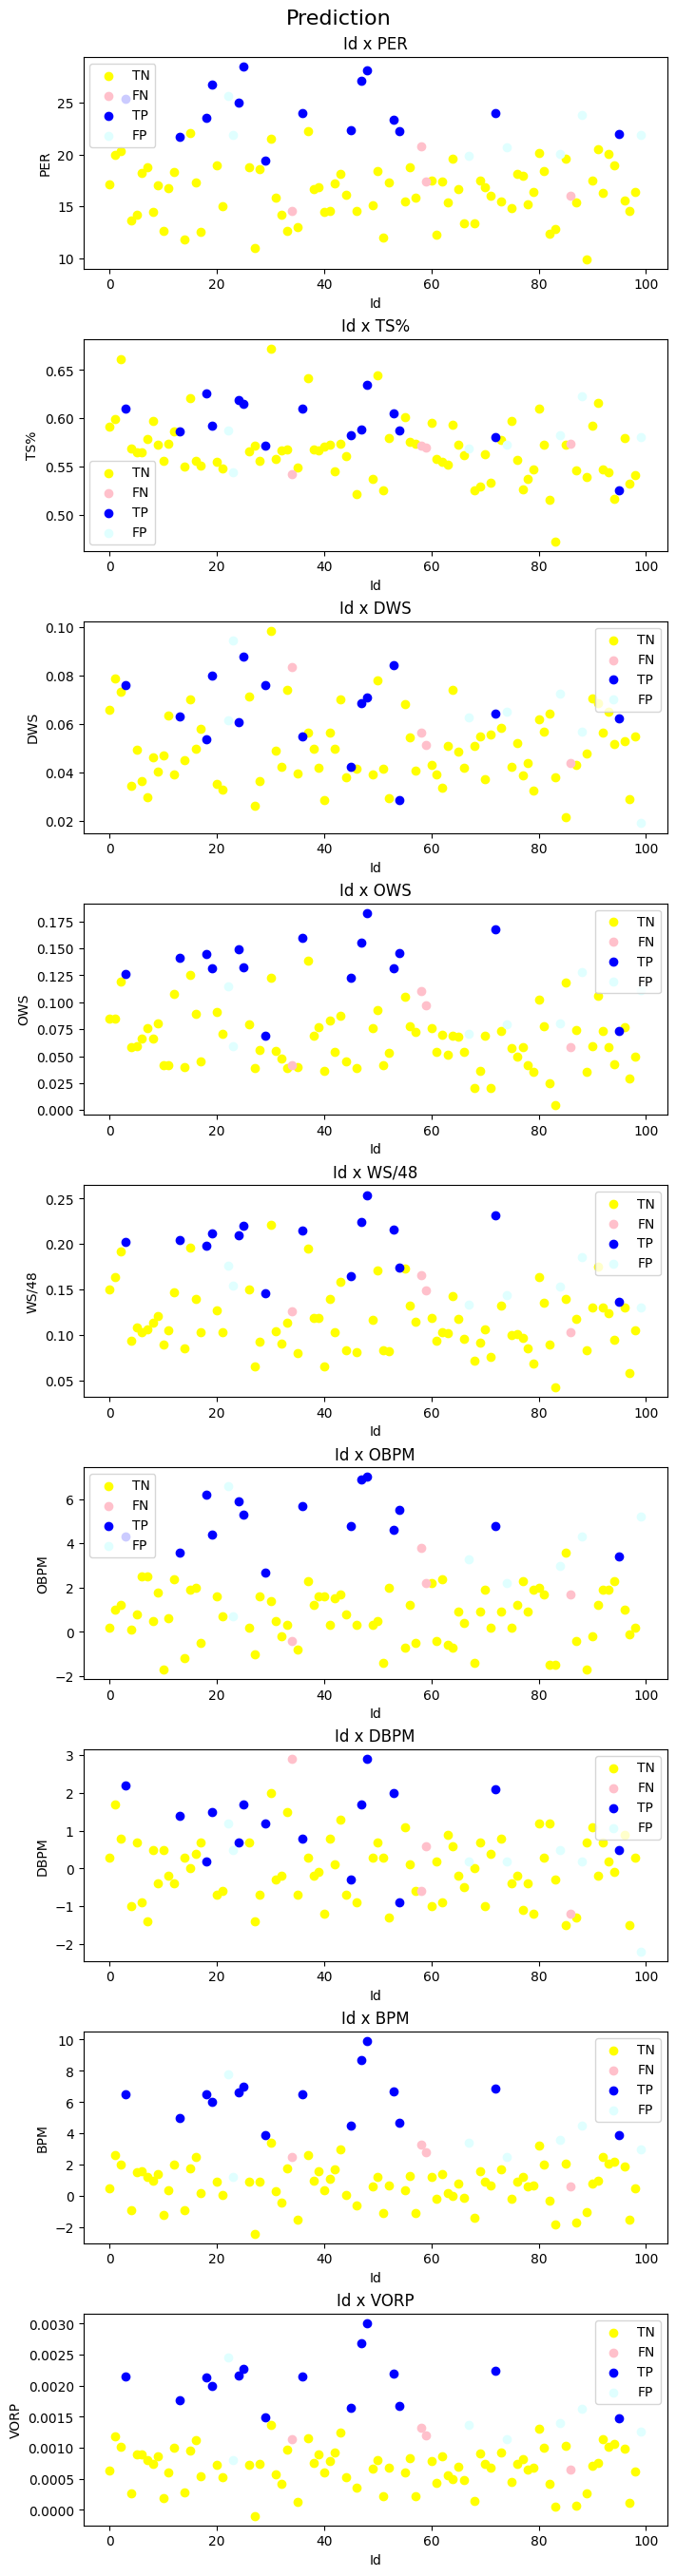

In [50]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process with manual feature selection")

train_test_pipeline(model_RFC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_manual, True)

# Adaboost

## Model definition

In [21]:
# Model definition

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

## Adaboost with no feature selection

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.6081410256410257
Cross validation mean recall on training set:  0.4428571428571428
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  75
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  6
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porte

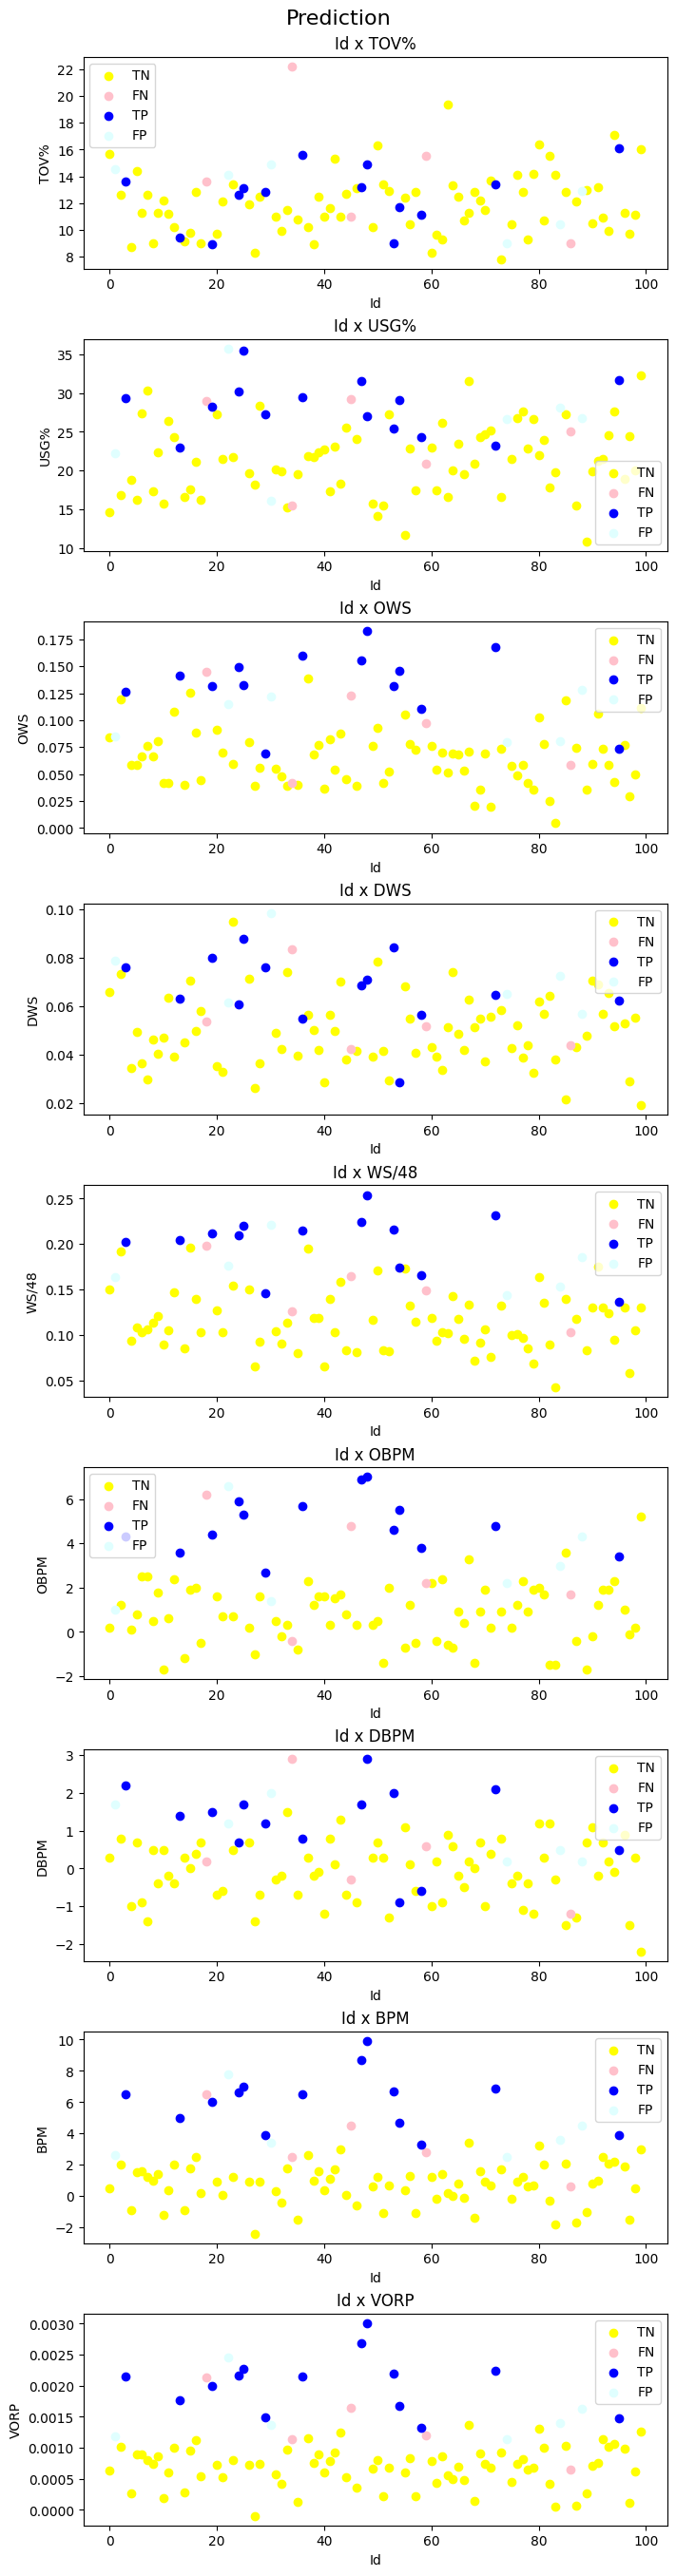

In [53]:
# Training and test process (no scaling) with no feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_ABC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns[:], True)

## Adaboost with feature selection

### RFECV

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 4
Selected features:
['OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.5555622009569378
Cross validation mean recall on training set:  0.42952380952380953
Feature Columns (list) used for training and test process: 
['OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 74
Predicted positives: 26
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  2
True positives (how many of the predicts are really positive):  17
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26     Derrick Favors
82       Marcus Smart
68    Markieff Morris
77       Derrick Rose
55       Kevon Looney
           ...       
76      Julius Randle
31       Aaron Gordon
73    Otto Porter Jr.
40        Buddy Hield
83          

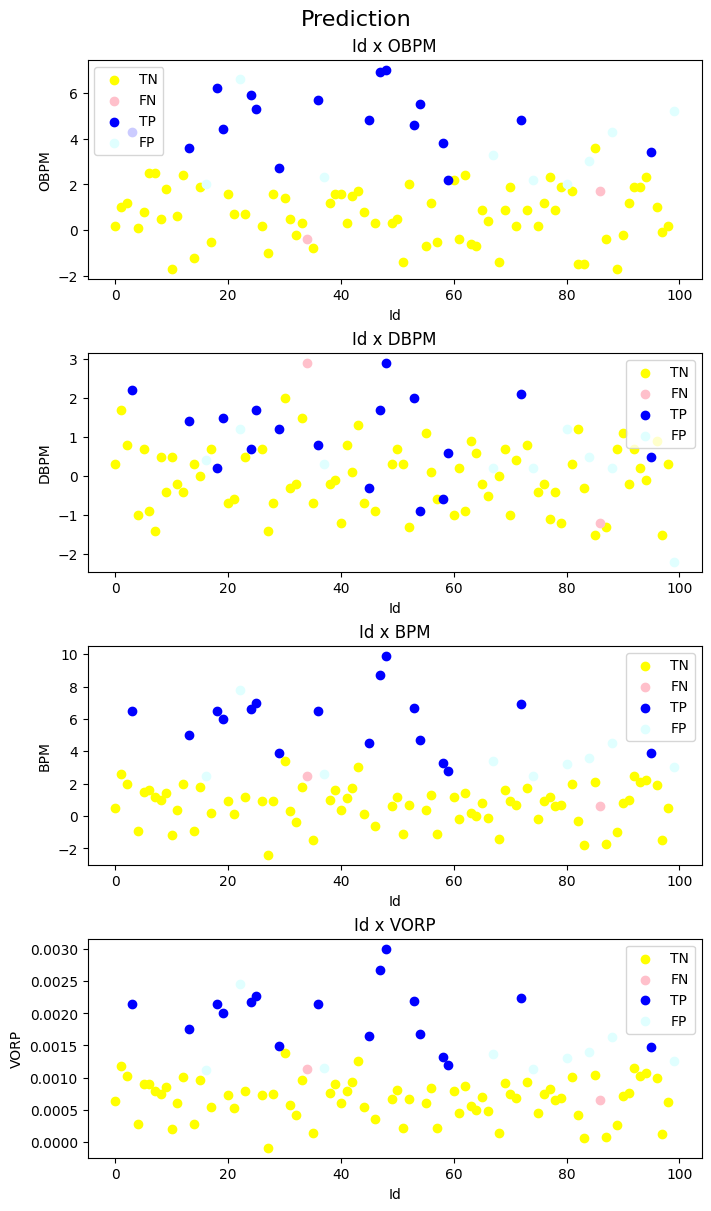

In [54]:
# Training and test process (no scaling) with rfecv feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_ABC_rfecv = select_features_rfecv(base_estimator, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_ABC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_ABC_rfecv, True)

### Select k-best

In [105]:
# Training and test process (no scaling) with skb feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_ABC_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_ABC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_ABC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.6333333333333333
Cross validation mean recall on training set:  0.44000000000000006
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 74
Predicted positives: 26
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  2
True positives (how many of the predicts are really positive):  17
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76   

### Select from model

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 5
Selected features:
['TS%', 'FTr', 'USG%', 'DWS', 'VORP']
Cross validation mean precision on training set:  0.5757575757575757
Cross validation mean recall on training set:  0.4542857142857143
Feature Columns (list) used for training and test process: 
['TS%', 'FTr', 'USG%', 'DWS', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 74
Predicted positives: 26
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  2
True positives (how many of the predicts are really positive):  17
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Bud

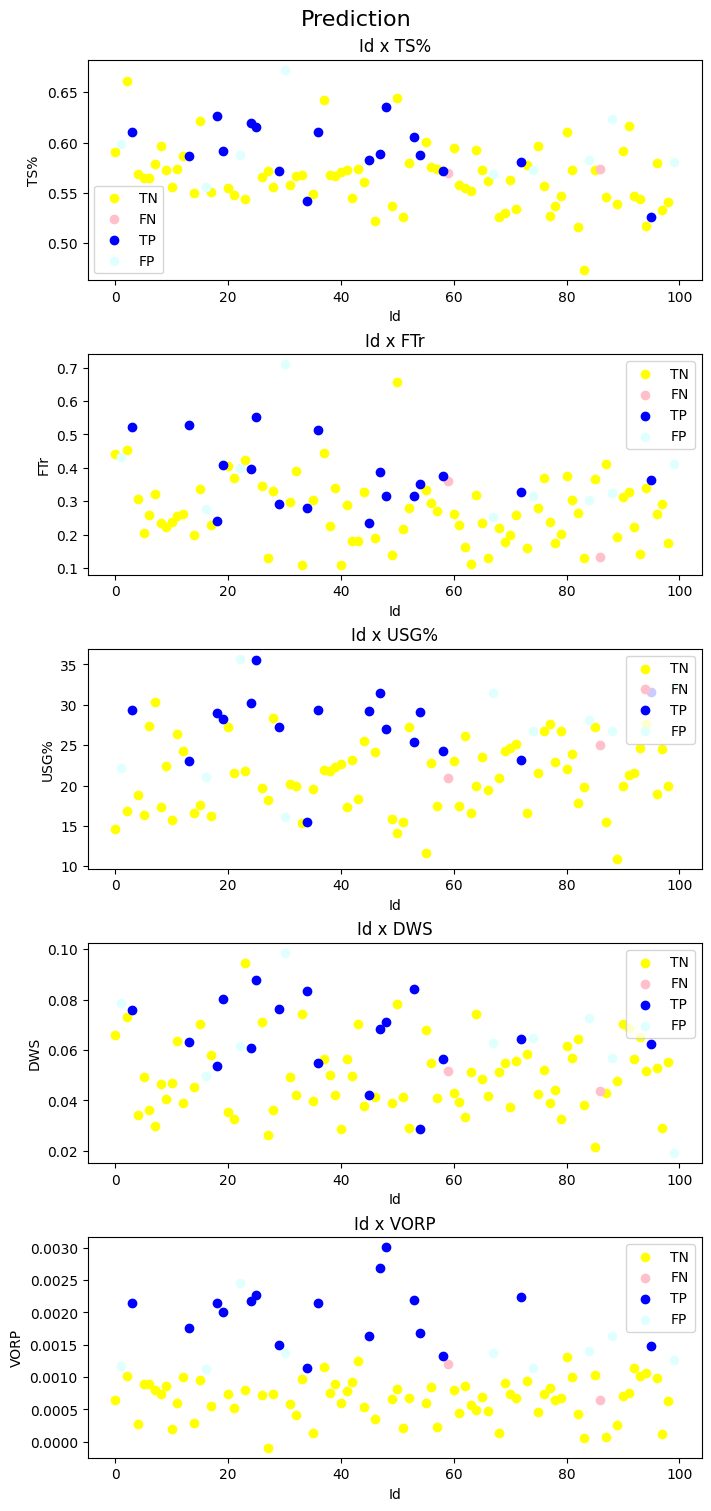

In [56]:
# Training and test process (no scaling) with sfm feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_ABC_sfm = select_features_sfm(model_ABC, training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_ABC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_ABC_sfm, True)

## Adaboost with manual feature selection

In [109]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

### Training and test process

In [110]:
# Training and test process (no scaling) with manual feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_ABC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.5517460317460318
Cross validation mean recall on training set:  0.42666666666666664
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 76
Predicted positives: 24
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 

# Gradientboost

## Model definition

In [146]:
# Model definition

model_GBC = GradientBoostingClassifier(random_state=23)

## Gradient boost with no feature selection

In [147]:
# Training and test process (no scaling) with no feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_GBC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns[:], False)

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.5097435897435897
Cross validation mean recall on training set:  0.4685714285714285
Feature Columns (list) used for training and test process: 
['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porte

## Gradient boost with feature selection

### RFECV

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 4
Selected features:
['OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.5571428571428572
Cross validation mean recall on training set:  0.3876190476190476
Feature Columns (list) used for training and test process: 
['OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83 

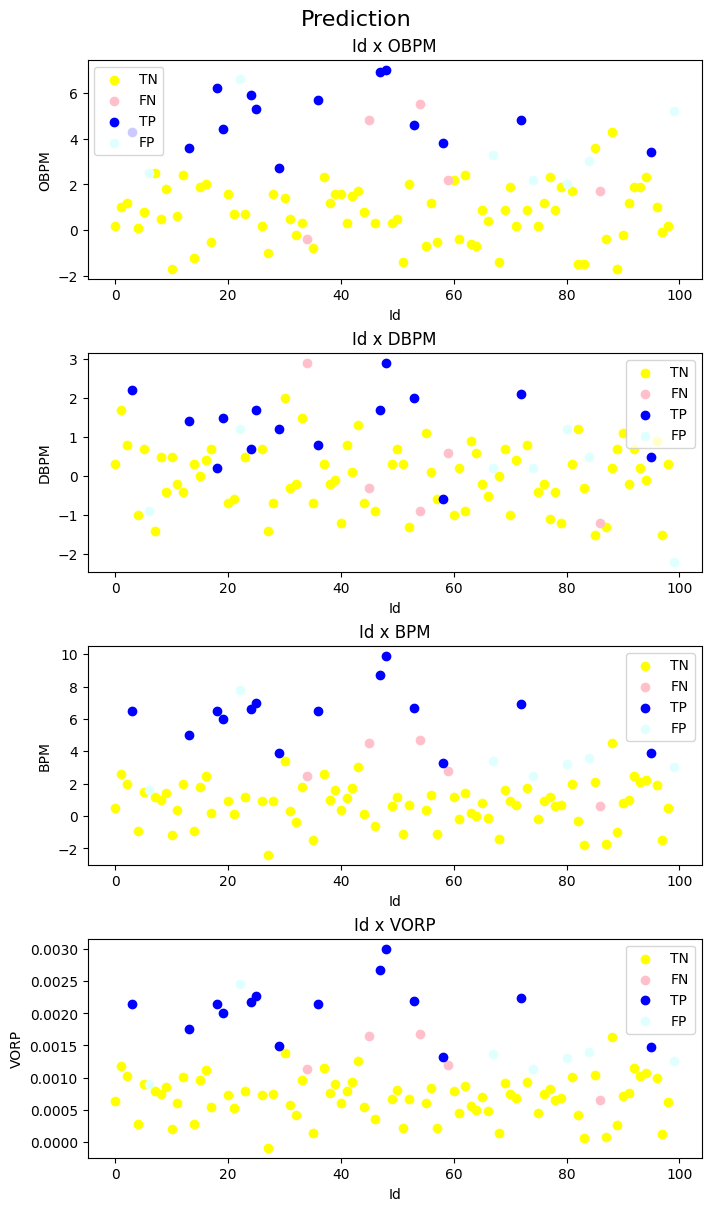

In [58]:
# Training and test process (no scaling) with rfecv feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_GBC_rfecv = select_features_rfecv(tree.DecisionTreeClassifier(max_depth=1), training_advanced_prepared.copy(),
                                                    valid_advanced_columns[:])

train_test_pipeline(model_GBC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_GBC_rfecv, True)

### Select k-best

In [59]:
# Training and test process (no scaling) with skb feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_GBC_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_GBC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_GBC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Cross validation mean precision on training set:  0.6140756302521009
Cross validation mean recall on training set:  0.4533333333333333
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 79
Predicted positives: 21
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76    

### Select From Model

In [61]:
# Training and test process (no scaling) with sfm feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with sfm feature selection")

# model_GBC?
selected_features_GBC_sfm = select_features_sfm(tree.DecisionTreeClassifier(max_depth=1), training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_pipeline(model_GBC, training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_GBC_sfm, False)

Training and test process (no scaling) with sfm feature selection
Optimal number of features: 1
Selected features:
['VORP']
Cross validation mean precision on training set:  0.3776012223071047
Cross validation mean recall on training set:  0.2761904761904762
Feature Columns (list) used for training and test process: 
['VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 75
Predicted positives: 25
True negatives (how many of the predicts are really negative):  72
False negatives (predicted negatives that are actual positive):  3
True positives (how many of the predicts are really positive):  16
False positives (predicted positives that are actual negative):  9
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 72, dt

## GradientBoost with manual feature selection

In [36]:
# My feature selection

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

### Training and test process

In [159]:
# Training and test process (no scaling) with manual feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_GBC, training_advanced_prepared, test_advanced_prepared, selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.5773448773448774
Cross validation mean recall on training set:  0.4542857142857143
Feature Columns (list) used for training and test process: 
['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  73
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  8
PLayer not Hof (True Negatives):
26      Derrick Favors
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
37    Montrezl Harrell
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 7

# XGBoost

In [ ]:
def train_test_xboost_pipeline(train_n_df, test_n_df, sel_features, plotted):
    X_train, y_train = train_n_df[sel_features], train_n_df['Hof']

    X_test, y_test = test_n_df[sel_features], test_n_df['Hof']

    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'lambda': 1,
        'alpha': 0,
        'seed': 23
    }

    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)

    preds = bst.predict(dtest)
    y_pred = pd.Series([1 if p > 0.5 else 0 for p in preds], index=test_n_df.index)

    fig, ax, class_p = evaluating_classification_model(y_pred, y_test, test_n_df, sel_features, 'Prediction', plotted)
    # y_proba_df, y_proba_diff_df = probability_hof_comparing(bst, X_test, test_n_df)
    # return { 'figure' : fig,
    #          'axes' : ax,
    #          'classes_p' : class_p}

## XGboost with no feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with no feature selection

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_xboost_pipeline(training_advanced_prepared.copy(), test_advanced_prepared.copy(), valid_advanced_columns, False)

## XGboost with Select k-best feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_skb = select_features_skb(training_advanced_prepared.copy(), valid_advanced_columns[:])

train_test_xboost_pipeline(training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_skb, False)

## XGboost with manual feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

print("Training and test process (no scaling and no weighted classes) with manual feature selection")

selected_features_manual = ['PER', 'TS%', 'DWS', 'OWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_test_xboost_pipeline(training_advanced_prepared.copy(), test_advanced_prepared.copy(), selected_features_manual, False)